In [1]:
#pip install catboost <- run first time this notebook is executed

In [2]:
import pandas as pd
from catboost import CatBoostRegressor
import datetime
from sklearn import preprocessing
import numpy as np
from matplotlib import pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_parquet('dataframe_forecasting_with_features.parquet')

In [5]:
def predict_horizon(model, training_df, test_df, feature_list, num_predictions=8):
    start_period = 0
    end_period = num_predictions
    prediction_list = []
    MAPE_list = []
    
    # We generate an encoder for ns feature
    if 'Country' in feature_list:
        ns_encoder = preprocessing.LabelEncoder()
        training_df['Country'] =  ns_encoder.fit_transform(training_df['Country'])
    
    x_training_df = training_df[feature_list].copy()
    y_training_df = training_df['Cases'].copy().to_frame()
    model.fit(x_training_df, np.ravel(y_training_df))
    
    # Predicting on test set, while end period is not equal to end of length of test_df
    while end_period <= len(test_df):
        # Collect features from start to end (67 hours) and predict
        features_df = test_df[feature_list][start_period:end_period].copy()
        if 'Country' in feature_list:
            features_df['Country'] = ns_encoder.transform(features_df['Country'])
        true_df = test_df[['Cases']][start_period:end_period].copy()
        predictions = model.predict(features_df)
       
        # Add the predicted data
        predicted_df = pd.DataFrame(predictions, columns=['predicted'])
        predicted_df.index = true_df.index.copy()        
        prediction_list.extend(predictions)
        # Calculate MAPE per prediction (hour) and MAPE per horizon
        MAPE_list.extend(MAPE(true_df, predicted_df, whole_horizon=False))
        # Move to next period
        start_period += 1
        end_period += 1
    
    test_df = test_df.assign(Predicted=prediction_list)
    test_df = test_df.assign(MAPE_values=MAPE_list)    
    return test_df


In [6]:
def MAPE(true_df, predicted_df, column_name = 'Cases', whole_horizon=True):
    """""Mean absolute percent error
    Parameters
    ----------
    true_df         : a Dataframe with observed/true values
    predicted_df    : a Dataframe with predicted values
    column_name     : name of the column in the DF with the true/predicted values (assuming same name)
 
    Returns
    -------
    If whole_horizon==True, a unique MAPE value for the whole horizon
    If whole_horizon==False, a vector of MAPE values for each hour of the predicted horizon
    """
    # Check for zero values in the true vector
    if true_df[column_name].isin([0]).any():
            print('True_df contains a 0 error, will result in nan in MAPE')
    # 
    sum_observed = true_df['Cases'].sum()
    abs_error_predicted = np.abs(true_df['Cases']-predicted_df['predicted'])
    #
    if whole_horizon == True:
        MAPE = 100 * abs_error_predicted.sum() / sum_observed
    else:
        MAPE = 100 * abs_error_predicted / (sum_observed/len(true_df))
    #
    return MAPE

In [7]:
def true_predicted_fig(true_df, predicted_df, title_str):
    fig,ax = plt.subplots(figsize=[12,4])
    p_t_max = np.max(np.maximum(true_df[:8]['Cases'].values,predicted_df[:8]['Predicted'].values))
    p_t_min = np.min(np.minimum(true_df[:8]['Cases'].values,predicted_df[:8]['Predicted'].values))
    t1 = ax.plot(true_df.index[:8], true_df[:8]['Cases'], 'black')
    ax.set_ylabel('Cases')
    ax.tick_params(axis='x', rotation=45)
    ax.set_title(title_str)
    p1 = ax.plot(predicted_df.index[:8], predicted_df[:8]['Predicted'], 'Red', linewidth=3)
    ax.legend((t1[0], p1[0]), ('True', 'Predicted'), loc=1, frameon=True)

In [8]:
def accumulated_dataframe_column(df_test,cluster_CB_df):
    test_start_value = df_test.loc[df_test.index == datetime.datetime(2020,9,9), 'cases_tot'].values[0]
    cluster_CB_df['Accumulated_Prediction']=0
    cluster_CB_df['Accumulated_Prediction'][0] = test_start_value + cluster_CB_df['Predicted'][0]
    for i in range(1,len(cluster_CB_df)):
        cluster_CB_df['Accumulated_Prediction'][i] = cluster_CB_df['Accumulated_Prediction'][i-1]+cluster_CB_df['Predicted'][i]
    return cluster_CB_df

## Selecting test countries

In [9]:
Algeria_df = df[df['Country'].isin(['Algeria'])]

In [10]:
test_1_df =  Algeria_df[(Algeria_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Algeria_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [11]:
Austria_df = df[df['Country'].isin(['Austria'])]

In [12]:
test_2_df =  Austria_df[(Austria_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Austria_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [13]:
Bangladesh_df = df[df['Country'].isin(['Bangladesh'])]

In [14]:
test_3_df =  Bangladesh_df[(Bangladesh_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Bangladesh_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [15]:
Croatia_df = df[df['Country'].isin(['Croatia'])]

In [16]:
test_4_df =  Croatia_df[(Croatia_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Croatia_df.index.date <= datetime.date(2020, 9, 17))].copy()

## Test country 1, Algeria

In [17]:
training_1_df = Algeria_df[(Algeria_df.index.date >= datetime.date(2020, 3, 1)) & 
                    (Algeria_df.index.date <= datetime.date(2020, 9, 9))].copy()

In [18]:
# Generate model
feature_list = ['Month','Day','prev_case']#,'Weekend','cases_tot']
params= {'iterations': 5000, 'silent': True}
model = CatBoostRegressor(**params)
Algeria_CB_df = predict_horizon(model=model, training_df=training_1_df.copy(), 
                                                             test_df=test_1_df.copy(),
                                                             feature_list=feature_list)

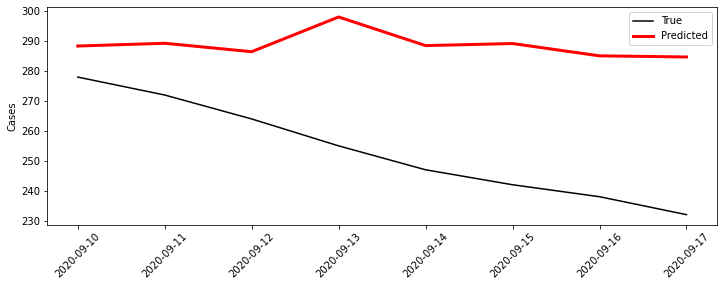

In [19]:
title_str =''
true_predicted_fig(test_1_df,Algeria_CB_df,title_str)

In [20]:
Algeria_CB_df = accumulated_dataframe_column(Algeria_df,Algeria_CB_df)

In [21]:
Algeria_CB_df

,Cases,Country,cases_tot,Month,Day,prev_case,Weekend,Predicted,MAPE_values,Accumulated_Prediction
Date,,,,,,,,,,
2020-09-10,278.0,Algeria,47216.0,9,3,285.0,0.0,288.381168,4.095135,47226
2020-09-11,272.0,Algeria,47488.0,9,4,278.0,0.0,289.303386,6.825793,47515
2020-09-12,264.0,Algeria,47752.0,9,5,272.0,1.0,286.484957,8.869806,47801
2020-09-13,255.0,Algeria,48007.0,9,6,264.0,1.0,298.094039,16.999621,48099
2020-09-14,247.0,Algeria,48254.0,9,0,255.0,0.0,288.527842,16.381792,48387
2020-09-15,242.0,Algeria,48496.0,9,1,247.0,0.0,289.215689,18.625518,48676
2020-09-16,238.0,Algeria,48734.0,9,2,242.0,0.0,285.099691,18.579760,48961
2020-09-17,232.0,Algeria,48966.0,9,3,238.0,0.0,284.726188,20.799285,49245


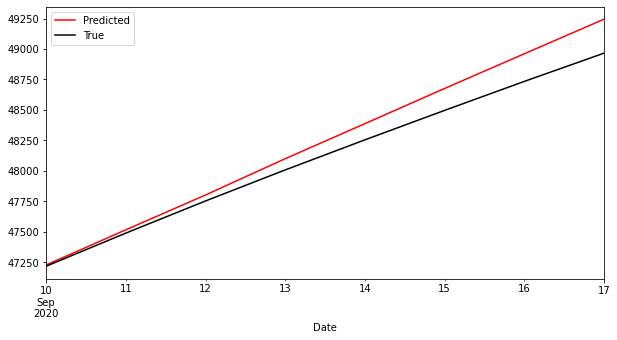

In [22]:
Algeria_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(10,5))

## Test country 2, Austria

In [23]:
training_2_df = Austria_df[(Austria_df.index.date >= datetime.date(2020, 3, 1)) & 
                    (Austria_df.index.date <= datetime.date(2020, 9, 9))].copy()

In [24]:
# Generate model
feature_list = ['Month','Day','prev_case']#,'Weekend','cases_tot']
params= {'iterations': 5000, 'silent': True}
model = CatBoostRegressor(**params)
Austria_CB_df = predict_horizon(model=model, training_df=training_2_df.copy(), 
                                                             test_df=test_2_df.copy(),
                                                             feature_list=feature_list)

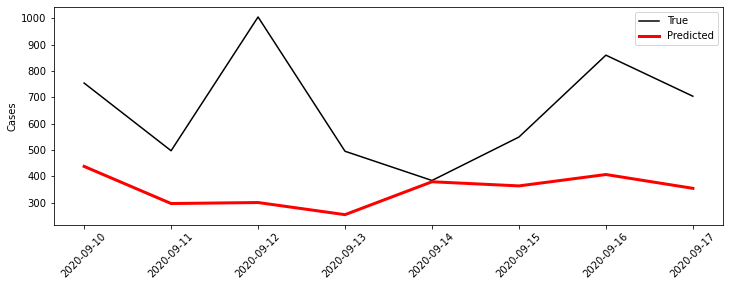

In [25]:
title_str =''
true_predicted_fig(test_2_df,Austria_CB_df,title_str)

In [26]:
Austria_CB_df = accumulated_dataframe_column(Austria_df,Austria_CB_df)

In [27]:
Austria_CB_df

,Cases,Country,cases_tot,Month,Day,prev_case,Weekend,Predicted,MAPE_values,Accumulated_Prediction
Date,,,,,,,,,,
2020-09-10,754.0,Austria,30954.0,9,3,495.0,0.0,437.492245,48.248133,30637
2020-09-11,497.0,Austria,31451.0,9,4,754.0,0.0,296.491934,30.565254,30933
2020-09-12,1005.0,Austria,32456.0,9,5,497.0,1.0,300.264326,107.429219,31233
2020-09-13,495.0,Austria,32951.0,9,6,1005.0,1.0,254.224167,36.703633,31487
2020-09-14,384.0,Austria,33335.0,9,0,495.0,0.0,379.184089,0.734133,31866
2020-09-15,549.0,Austria,33884.0,9,1,384.0,0.0,363.431341,28.287905,32229
2020-09-16,860.0,Austria,34744.0,9,2,549.0,0.0,406.686282,69.102701,32635
2020-09-17,704.0,Austria,35448.0,9,3,860.0,0.0,354.200483,53.323097,32989


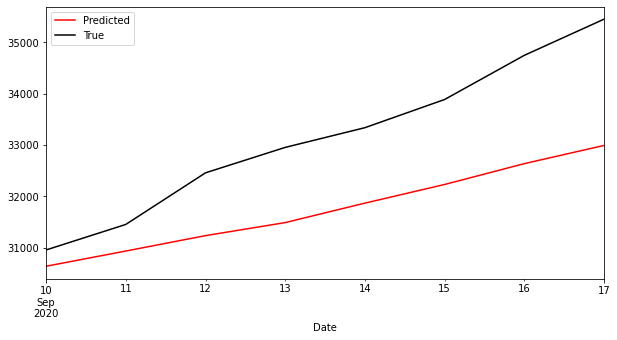

In [28]:
Austria_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(10,5))

## Test country 3, Bangladesh

In [29]:
training_3_df = Bangladesh_df[(Bangladesh_df.index.date >= datetime.date(2020, 3, 1)) & 
                    (Bangladesh_df.index.date <= datetime.date(2020, 9, 9))].copy()

In [30]:
# Generate model
feature_list = ['Country','Month','Day','prev_case']#,'Weekend']#,'cases_tot']
params= {'iterations': 5000, 'silent': True}
model = CatBoostRegressor(**params)
Bangladesh_CB_df = predict_horizon(model=model, training_df=training_3_df.copy(), 
                                                             test_df=test_3_df.copy(),
                                                             feature_list=feature_list)



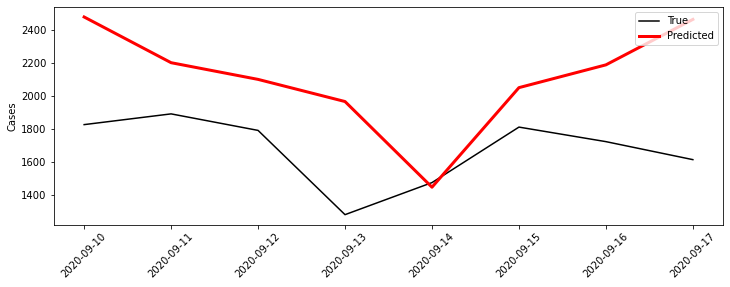

In [31]:
title_str =''
true_predicted_fig(test_3_df,Bangladesh_CB_df,title_str)

In [32]:
Bangladesh_CB_df = accumulated_dataframe_column(Bangladesh_df,Bangladesh_CB_df)

In [33]:
Bangladesh_CB_df

,Cases,Country,cases_tot,Month,Day,prev_case,Weekend,Predicted,MAPE_values,Accumulated_Prediction
Date,,,,,,,,,,
2020-09-10,1827.0,Bangladesh,331078.0,9,3,1892.0,0.0,2478.519146,38.838697,331729
2020-09-11,1892.0,Bangladesh,332970.0,9,4,1827.0,0.0,2201.811538,18.468646,333930
2020-09-12,1792.0,Bangladesh,334762.0,9,5,1892.0,1.0,2100.764519,18.406231,336030
2020-09-13,1282.0,Bangladesh,336044.0,9,6,1792.0,1.0,1966.714742,40.817570,337996
2020-09-14,1476.0,Bangladesh,337520.0,9,0,1282.0,0.0,1448.206057,1.656867,339444
2020-09-15,1812.0,Bangladesh,339332.0,9,1,1476.0,0.0,2050.828953,14.237195,341494
2020-09-16,1724.0,Bangladesh,341056.0,9,2,1812.0,0.0,2188.715875,27.702884,343682
2020-09-17,1615.0,Bangladesh,342671.0,9,3,1724.0,0.0,2463.856919,50.602499,346145


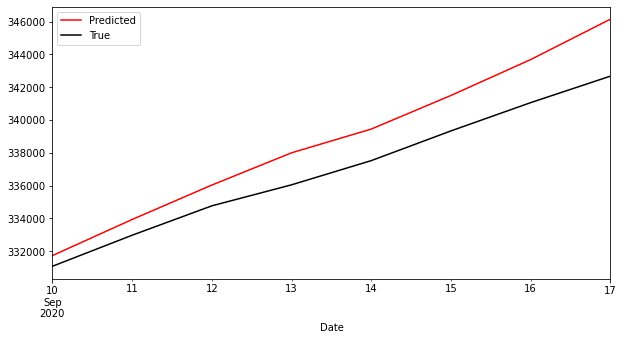

In [34]:
Bangladesh_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(10,5))

## Test country 4, Croatia

In [35]:
training_4_df = Croatia_df[(Croatia_df.index.date >= datetime.date(2020, 3, 1)) & 
                    (Croatia_df.index.date <= datetime.date(2020, 9, 9))].copy()

In [36]:
# Generate model
feature_list = ['Country','Month','Day','prev_case']#,'Weekend']#,'cases_tot']
params= {'iterations': 5000, 'silent': True}
model = CatBoostRegressor(**params)
Croatia_CB_df = predict_horizon(model=model, training_df=training_4_df.copy(), 
                                                             test_df=test_4_df.copy(),
                                                             feature_list=feature_list)

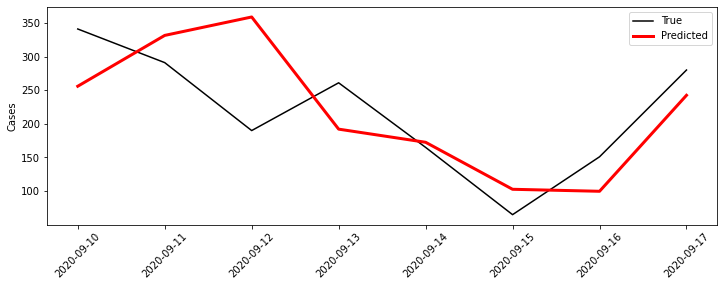

In [37]:
title_str =''
true_predicted_fig(test_4_df,Croatia_CB_df,title_str)

In [38]:
Croatia_CB_df = accumulated_dataframe_column(Croatia_df,Croatia_CB_df)

In [39]:
Croatia_CB_df

,Cases,Country,cases_tot,Month,Day,prev_case,Weekend,Predicted,MAPE_values,Accumulated_Prediction
Date,,,,,,,,,,
2020-09-10,341.0,Croatia,12626.0,9,3,204.0,0.0,255.897314,39.037929,12540
2020-09-11,291.0,Croatia,12917.0,9,4,341.0,0.0,331.447521,18.553909,12871
2020-09-12,190.0,Croatia,13107.0,9,5,291.0,1.0,358.841949,77.450435,13229
2020-09-13,261.0,Croatia,13368.0,9,6,190.0,1.0,192.116374,31.597994,13421
2020-09-14,165.0,Croatia,13533.0,9,0,261.0,0.0,172.598023,3.485331,13593
2020-09-15,65.0,Croatia,13598.0,9,1,165.0,0.0,102.714366,17.300168,13695
2020-09-16,151.0,Croatia,13749.0,9,2,65.0,0.0,99.746425,23.510814,13794
2020-09-17,280.0,Croatia,14029.0,9,3,151.0,0.0,242.432243,17.232916,14036


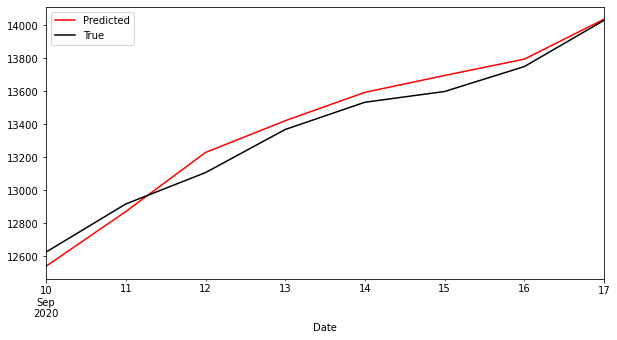

In [40]:
Croatia_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(10,5))